In [2]:
import numpy as np
import matplotlib.pyplot as plt

import jax
from functools import partial
import jax.numpy as jnp

plt.rcParams['figure.figsize'] = [12, 8]

import time
from tqdm import tqdm

from Dynamics import logistic_map, lorentz_map
from Kernels import ext_kernel
from Losses import rho_comp

from Optimizer import KernelSOS, flow_rho_relative
from DataManager import get_curr_data, sample_points
from utils import get_predict_func, gen_traj, predict_series, get_pred_funcs

jax.config.update("jax_enable_x64", True)


%load_ext autoreload
%autoreload 2

In [167]:
# larger learning rate appears to work well (lr=0.3) gives loss of 0.021
def main_flow(y_idx):
    lr = 0.3
    num_steps = 200

    k_func = ext_kernel

    theta = np.ones(10)

    theta_star, losses = flow_rho_relative(theta, k_func, X_batch, y_batch[:, y_idx], X_sub, y_sub[:, y_idx], num_steps, lr)
    print("flow min", np.min(losses))

    plt.plot(losses)
    
    return theta_star
    
def main_sos(y_idx):
    # Setup for Kernel SOS.
    thetas = sample_points([[0.001, 10]] * 10, 200)

    loss = lambda t: rho_comp(t, ext_kernel, X_batch, y_batch[:, y_idx], X_sub, y_sub[:, y_idx])

    fs = jnp.array([loss(t) for t in tqdm(thetas)])
    thetas = jnp.array(thetas)

    alpha0 = jnp.ones(len(fs))
    alpha0 /= jnp.sum(alpha0)
    theta_star, res, alpha = KernelSOS(alpha0, thetas, fs, loss, N=100, lmbda=0.001, eps=0.000001, sig=0.1)
    print("found min", np.min(res[:, 1]))
    print("sample min", np.min(fs))

    plt.plot(res[:, 1])
    return theta_star
    

In [168]:
# x_vec_0 = [0, 1, 1.05]
x_vec_0 = [0.5, 1.5, 2.5]

traj = jnp.array(gen_traj(lorentz_map(), x_vec_0, 1000))

X = traj[:-1]
Y = traj[1:]

X_batch, y_batch, X_sub, y_sub = get_curr_data(X, Y, 1000, 500)



# Y.idx 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


flow min 0.06737370694226141


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


found min 0.02485663168403962
sample min 0.029275128766418024


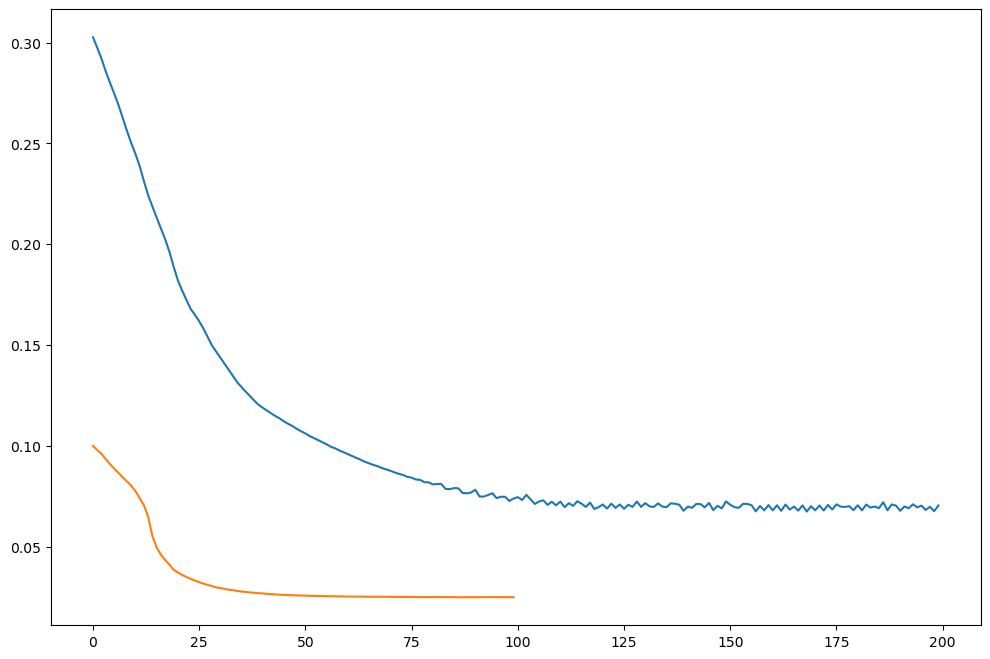

In [169]:
y_idx = 0

theta_star_flow_0 = main_flow(y_idx)
theta_star_sos_0 = main_sos(y_idx)

# Y.idx 1

In [ ]:
y_idx = 1

theta_star_flow_1 = main_flow(y_idx)
theta_star_sos_1 = main_sos(y_idx)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:50<00:00,  1.15s/it]


flow min 0.1570640096953303


 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 84/100 [00:31<00:05,  2.74it/s]

# Y.idx 2

In [ ]:
y_idx = 2

theta_star_flow_2 = main_flow(y_idx)
theta_star_sos_2 = main_sos(y_idx)

# Assessment

In [152]:
x_vec_0_test = [0.5, 1.5, 2.5]

x_vec_0_test = [0.7, 1.1, 2.]


traj = jnp.array(gen_traj(lorentz_map(), x_vec_0_test, 1000))

X = traj[:-1]
Y = traj[1:]

In [153]:
thetas_flow = jnp.array([theta_star_flow_0, theta_star_flow_1, theta_star_flow_2])
thetas_sos = jnp.array([theta_star_sos_0, theta_star_sos_1, theta_star_sos_2])

pred_funcs_flow = get_pred_funcs(thetas_flow, ext_kernel, X, Y)
pred_funcs_sos = get_pred_funcs(thetas_sos, ext_kernel, X, Y)

# Autoregressive

In [141]:
traj_preds_flow = predict_series(pred_funcs_flow, jnp.array(x_vec_0_test), 1000)
traj_preds_sos = predict_series(pred_funcs_sos, jnp.array(x_vec_0_test), 1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.53it/s]


In [149]:
print("flow", np.std(np.linalg.norm((traj - traj_preds_flow), axis=1)))
print("sos", np.std(np.linalg.norm((traj - traj_preds_sos), axis=1)))

flow 11.47677817685033
sos 8.594670700931122


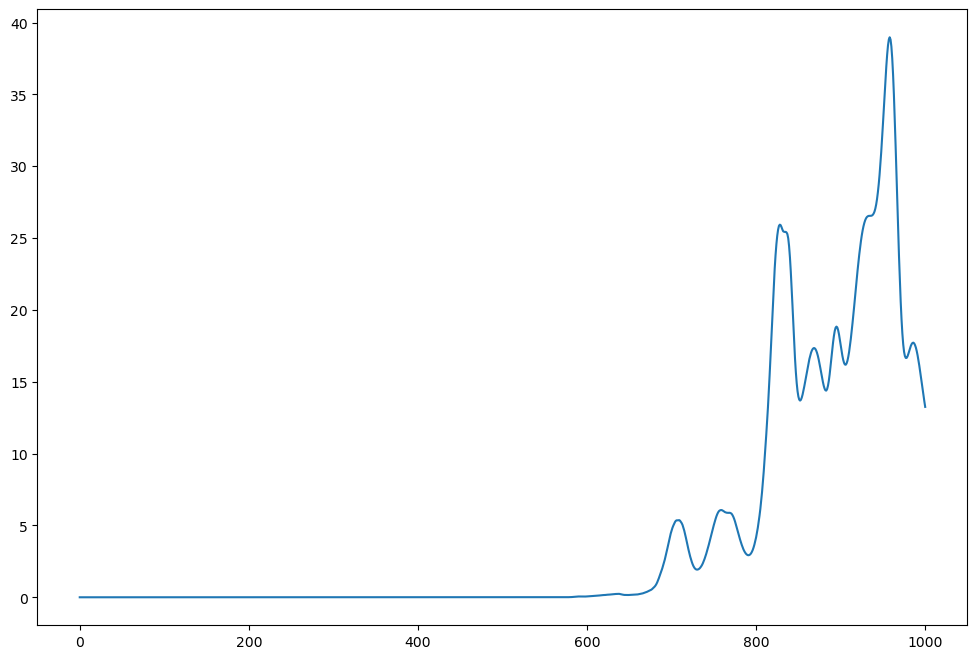

In [143]:
diff = np.linalg.norm((traj - traj_preds_sos), axis=1)

plt.plot(diff)
plt.show()

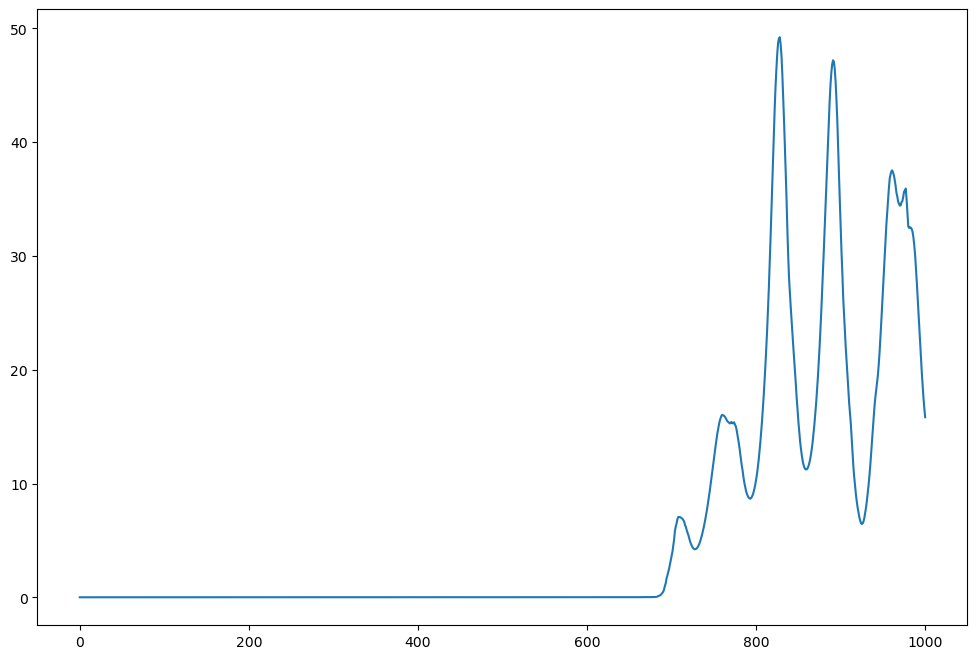

In [144]:
diff = np.linalg.norm((traj - traj_preds_flow), axis=1)

plt.plot(diff)
plt.show()

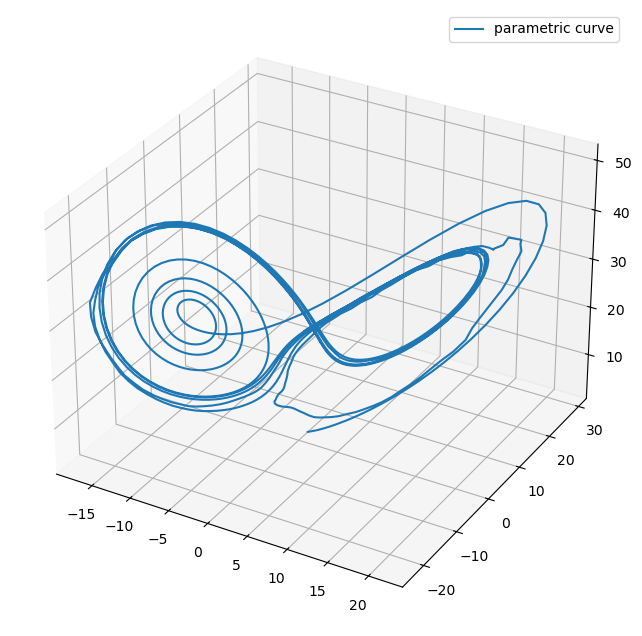

In [142]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(traj_preds_flow[:, 0], traj_preds_flow[:, 1], traj_preds_flow[:, 2], label='parametric curve')
ax.legend()

plt.show()

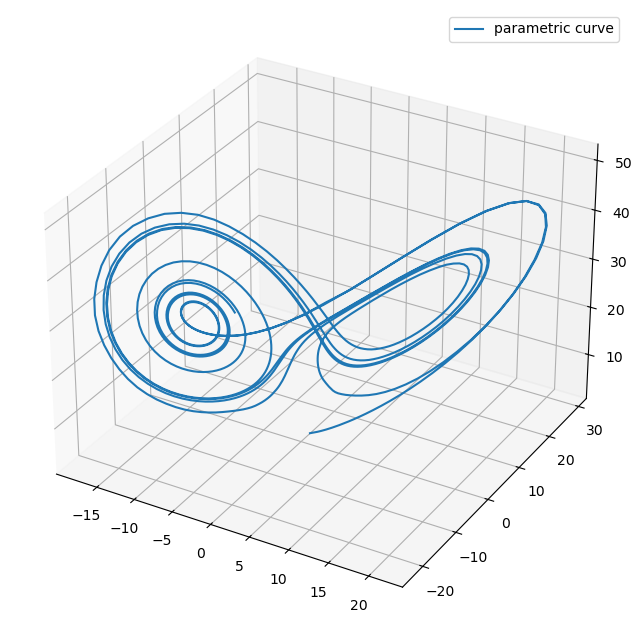

In [145]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(traj_preds_sos[:, 0], traj_preds_sos[:, 1], traj_preds_sos[:, 2], label='parametric curve')
ax.legend()

plt.show()

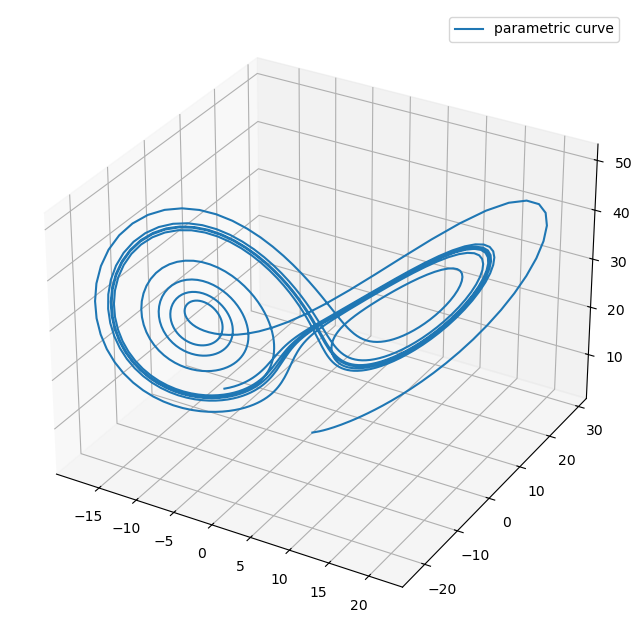

In [146]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='parametric curve')
ax.legend()

plt.show()

# Non-Autoregressive

In [ ]:
res_flow = []
res_sos = []
for x in tqdm(X):
    curr_res_flow = []
    curr_res_sos = []
    for k in range(3):
        curr_res_flow.append(pred_funcs_flow[k](x))
        curr_res_sos.append(pred_funcs_sos[k](x))
    res_flow.append(curr_res_flow)
    res_sos.append(curr_res_sos)
    
res = jnp.array(res)
jnp.std(jnp.linalg.norm(res - Y, axis=1))


